In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import regex as re

In [4]:
X, y = fetch_covtype(as_frame=True, return_X_y=True)

In [5]:
# splitting into train and test using a stratified split 
# and 80-20 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [6]:
# Describing the index of numerical and categorical variables
num_vars = X.columns[:10]
cat_vars = X.columns[10:]

In [7]:
# Visualizing pca and lda when reducing to 2 dimensions
pca_pipe = Pipeline([
    ("Scaling", StandardScaler()),
    ("PCA", PCA(n_components=2))
])
X_pca = pca_pipe.fit_transform(X_train[num_vars])

lda_pipe = Pipeline([
    ('Scaling', StandardScaler()),
    ("LDA", LinearDiscriminantAnalysis(n_components=2))
])

X_lda = lda_pipe.fit_transform(X_train[num_vars], y_train)

In [8]:
pca_data = pd.DataFrame(X_pca)
lda_data = pd.DataFrame(X_lda)
y_train_copy = pd.Series(y_train.copy()).reset_index(drop=True)
pca_data['y_train'] = y_train_copy
pca_data.rename(columns={0: "x1", 1: 'x2'}, inplace=True)

lda_data['y_train'] = y_train_copy
lda_data.rename(columns={0: "x1", 1: 'x2'}, inplace=True)


/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/

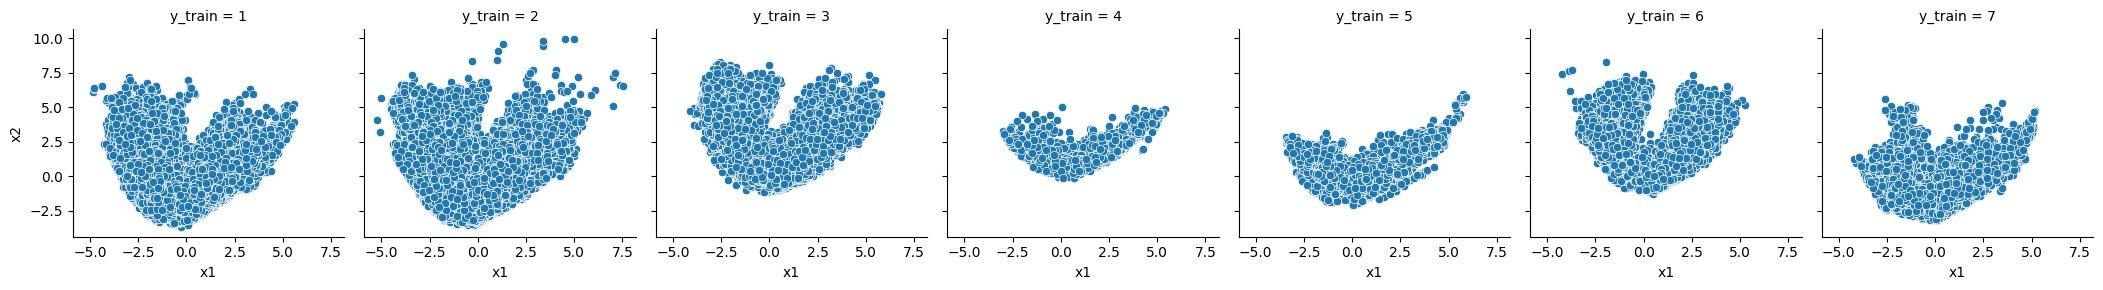

In [9]:
g = sns.FacetGrid(pca_data, col="y_train")
g.map(sns.scatterplot, 'x1', 'x2')

In [10]:
# It seems all of the variables have similar distributions when dimension is reduced by pca
# to two dimensions.

/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/cloud_practice/env/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/chris/Desktop/

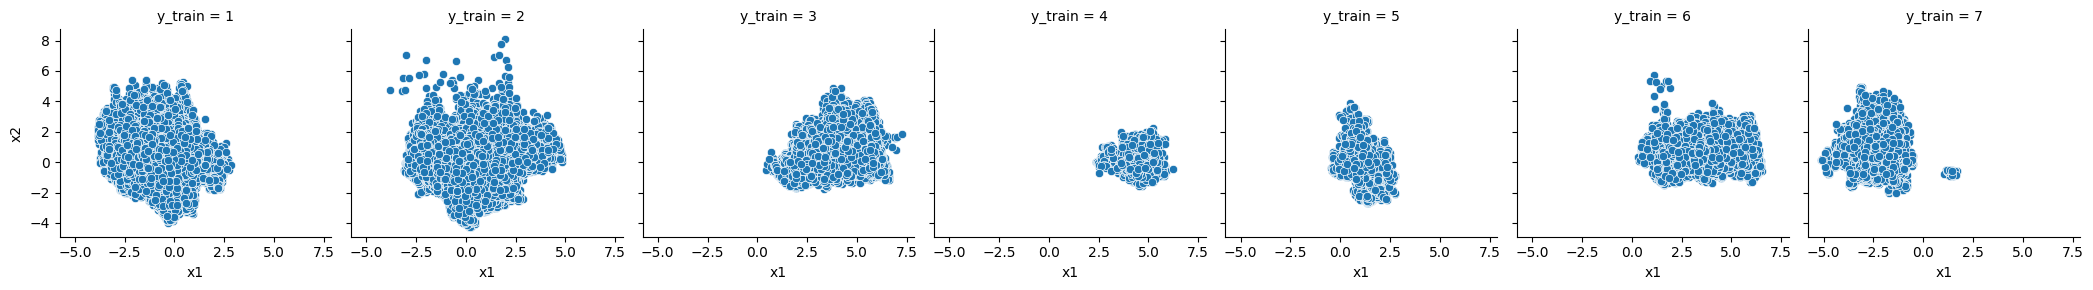

In [11]:
g = sns.FacetGrid(lda_data, col="y_train")
g.map(sns.scatterplot, 'x1', 'x2')

In [12]:
# lda is much more promising as a dimension reduction technique than pca because it 
# successfully groups the classes into more distinct areas.  Now I will grid search over 
# how many dimensions(if any) to reduce to through lda.  I will also explore whether 
# standard scaling before dimension reduction improves f1 score

In [13]:
num_pipe = Pipeline([
    ("Scaler", StandardScaler()),
    ("DimReduction", PCA())
])

In [14]:
ct = ColumnTransformer([
    ("num_pipe", num_pipe, num_vars)], remainder="passthrough")

clf = HistGradientBoostingClassifier(
    categorical_features=np.ones(10, dtype=bool),
    scoring="f1_macro"
)

pipe = Pipeline([("ct", ct), ("clf", clf)])

In [109]:
# generates a parameter grid that inputs the correct number categorical mask for each 
# dimension reduction configuration
def param_grid_generator():
    param_grid = []
    for i in range(2,7):
        params = {
            "ct__num_pipe__Scaler": [StandardScaler(), 'passthrough'],
            "ct__num_pipe__DimReduction": [LinearDiscriminantAnalysis(n_components=i)],
            "clf__categorical_features": [np.concatenate([
                np.zeros(i, dtype=bool), np.ones(44, dtype=bool)])]
            }
        param_grid.append(params)
    for i in range(3,9):
        params = {
            "ct__num_pipe__Scaler": [StandardScaler(), 'passthrough'],
            "ct__num_pipe__DimReduction": [PCA(n_components=i)],
            "clf__categorical_features": [np.concatenate([
                np.zeros(i, dtype=bool), np.ones(44, dtype=bool)])]
        }
        param_grid.append(params)
    params = {
        "ct__num_pipe__Scaler": [StandardScaler(), "passthrough"],
        "ct__num_pipe__DimReduction": ["passthrough"],
        "clf__categorical_features": [np.concatenate(
            [np.zeros(10, dtype=bool), np.ones(44, dtype=bool)])]}
    param_grid.append(params)
    return param_grid

In [110]:
param_grid = param_grid_generator()

In [111]:
output = GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring="f1_macro", verbose=3)

In [112]:
output.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END clf__categorical_features=[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True], ct__num_pipe__DimReduction=LinearDiscriminantAnalysis(n_components=2), ct__num_pipe__Scaler=StandardScaler();, score=0.611 total time=  24.3s
[CV 2/5] END clf__categorical_features=[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True], ct__num_pipe__DimReduction=LinearDiscriminantAnalysis(n_components=2), ct__num_pipe__Scaler=StandardScaler();, score=0.604 total time=  25.6s
[CV 3/5] END

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('Scaler',
                                                                                          StandardScaler()),
                                                                                         ('DimReduction',
                                                                                          PCA())]),
                                                                         Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noo...
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])],
                          'ct__num_pipe__DimReduction': ['passthrough'],
                          'ct__num_pipe__Scaler': [StandardScaler(),
                                                   'passthrough']}],
             scoring='f1_macro', verbose=3)

In [113]:
results = output.cv_results_
best_params = output.best_params_
best_score = output.best_score_
best_estimator = output.best_estimator_

In [129]:
results_df = pd.DataFrame(dict(
    # cat_features=results['param_clf__categorical_features'],
    dim_reduction=results['param_ct__num_pipe__DimReduction'],
    Scaler=results['param_ct__num_pipe__Scaler'],
    mean_score=results['mean_test_score']))

In [130]:
results_df

,dim_reduction,Scaler,mean_score
0,LinearDiscriminantAnalysis(n_components=2),StandardScaler(),0.605733
1,LinearDiscriminantAnalysis(n_components=2),passthrough,0.604256
2,LinearDiscriminantAnalysis(n_components=3),StandardScaler(),0.641899
3,LinearDiscriminantAnalysis(n_components=3),passthrough,0.650665
4,LinearDiscriminantAnalysis(n_components=4),StandardScaler(),0.674170
5,LinearDiscriminantAnalysis(n_components=4),passthrough,0.682798
6,LinearDiscriminantAnalysis(n_components=5),StandardScaler(),0.695572
7,LinearDiscriminantAnalysis(n_components=5),passthrough,0.694539
8,LinearDiscriminantAnalysis(n_components=6),StandardScaler(),0.704771
9,LinearDiscriminantAnalysis(n_components=6),passthrough,0.699731


In [131]:
# Adding 'n_numerical' column by using regex to find first number in a string
results_df['n_numerical'] = results_df['dim_reduction'].apply(
    lambda x: int(re.search(r'\d+', str(x)).group()) if 'n_components' in str(x) else 10)


In [132]:
# Dropping extra characters from dim reduction column
results_df['dim_reduction'] = results_df['dim_reduction'].apply(
    lambda x: str(x).split('(')[0])

In [133]:
# Dropping extra characters from Scaler column
results_df['Scaler'] = results_df['Scaler'].apply(
    lambda x: str(x).split('(')[0])

In [134]:
results_df

,dim_reduction,Scaler,mean_score,n_numerical
0,LinearDiscriminantAnalysis,StandardScaler,0.605733,2
1,LinearDiscriminantAnalysis,passthrough,0.604256,2
2,LinearDiscriminantAnalysis,StandardScaler,0.641899,3
3,LinearDiscriminantAnalysis,passthrough,0.650665,3
4,LinearDiscriminantAnalysis,StandardScaler,0.674170,4
5,LinearDiscriminantAnalysis,passthrough,0.682798,4
6,LinearDiscriminantAnalysis,StandardScaler,0.695572,5
7,LinearDiscriminantAnalysis,passthrough,0.694539,5
8,LinearDiscriminantAnalysis,StandardScaler,0.704771,6
9,LinearDiscriminantAnalysis,passthrough,0.699731,6


In [135]:
dim_reduced_df = results_df[:22].copy()
dim_reduced_df

,dim_reduction,Scaler,mean_score,n_numerical
0,LinearDiscriminantAnalysis,StandardScaler,0.605733,2
1,LinearDiscriminantAnalysis,passthrough,0.604256,2
2,LinearDiscriminantAnalysis,StandardScaler,0.641899,3
3,LinearDiscriminantAnalysis,passthrough,0.650665,3
4,LinearDiscriminantAnalysis,StandardScaler,0.674170,4
5,LinearDiscriminantAnalysis,passthrough,0.682798,4
6,LinearDiscriminantAnalysis,StandardScaler,0.695572,5
7,LinearDiscriminantAnalysis,passthrough,0.694539,5
8,LinearDiscriminantAnalysis,StandardScaler,0.704771,6
9,LinearDiscriminantAnalysis,passthrough,0.699731,6


In [139]:
passthrough_df = results_df[22:].copy()
passthrough_df

,dim_reduction,Scaler,mean_score,n_numerical
22,passthrough,StandardScaler,0.798417,10
23,passthrough,passthrough,0.791433,10


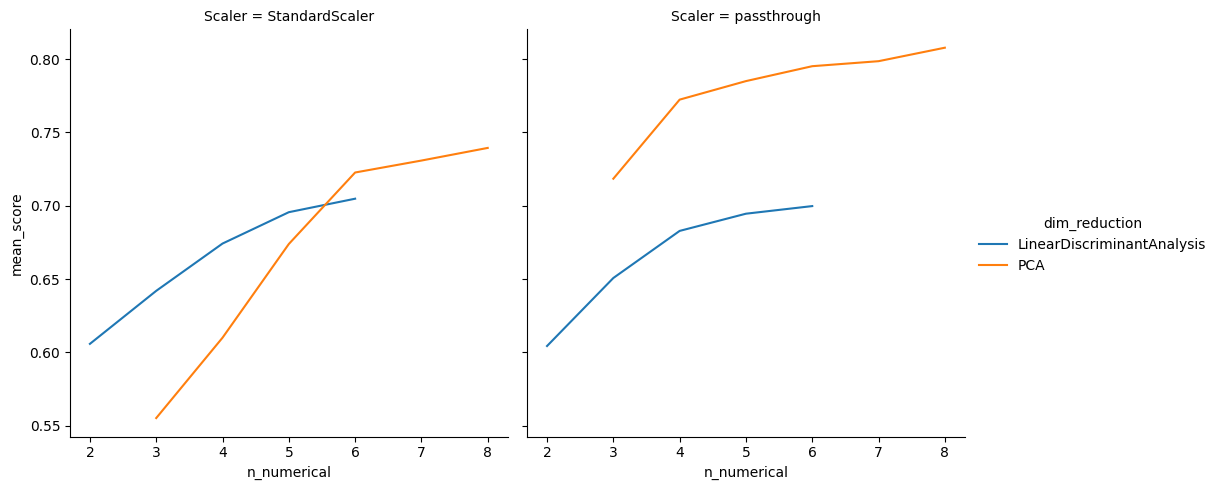

In [144]:
sns.relplot(
    data=dim_reduced_df, x="n_numerical", y="mean_score", col="Scaler", 
    hue="dim_reduction", kind="line"
)

In [ ]:
# With the correct number of variables chosen, pca will outperform lda regardless of 
# prior standardization 

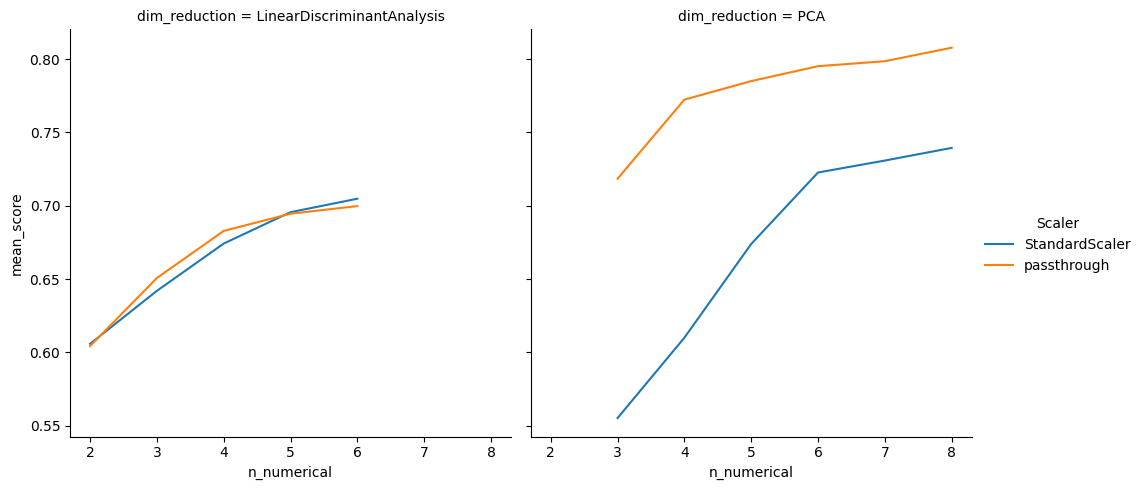

In [145]:
sns.relplot(
    data=dim_reduced_df, x="n_numerical", y="mean_score", col="dim_reduction", 
    hue="Scaler", kind="line"
)

In [146]:
# Interestingly, lda performed almost identically with and without standardization.  Pca
# on the other hand drastically improves when it is not standard scaled.  I would have to 
# think more carefully about exactly why this happens, but I am guessing that some 
# variance information is lost when scaling each variable to unit variance during standard
# scaling.

In [148]:
# Finally, when comparing the scores of no dimension reduction at all with the 
# non standardized pca, the results are very close.  Non standardized pca with both 7 and 8 
# dimensions slightly outperformed standardized data with no dimension reduction, with 
# 8 dimensions scoring higher than 7.

In [149]:
# If I wanted to be really thorough, I could run an experiment that repeated the grid 
# search 5 or 10 times with only the top candidates, and then select the winning model
# based on the parameters with the highest average score.  However, I will just choose 
# the model which had the highest results in the previous grid search, which was 
# non standardized pca with 8 dimensions.